In [1]:
from os import listdir
from tqdm import tqdm, trange
import hazm as hz
import numpy as np
import pandas as pd
flatten = lambda l: [item for sublist in l for item in sublist]

data_path = 'CA1_Data/train/'
data_names = listdir(data_path)
data_names

['culture', 'sport', 'technology', 'social', 'finance', 'politic']

In [2]:
import json
from nltk.lm import Vocabulary

# all_data = list()
# for name in data_names :
#     for i in tqdm(listdir(data_path+name)) :
#         all_data.append(open(data_path+name+'/'+i).read())
# for i in tqdm(listdir('./CA1_Data/test/')) :
#     all_data.append(open('./CA1_Data/test/'+i).read())
# all_data = '\n'.join(all_data)
# alphabet = np.unique(list(all_data)).tolist()
# all_data = Text_Processor.process_text(None,all_data)
# vocabulary = np.unique(hz.word_tokenize(all_data)).tolist()
# print('alphabet.json',end=' ')
# json.dump(alphabet, open('alphabet.json','w'))
# print('Done!')
# print('vocabulary.json',end=' ')
# json.dump(vocabulary, open('vocabulary.json','w'))
# print('Done!')

vocabulary = json.load(open('vocabulary.json'))
alphabet = json.load(open('alphabet.json'))

vocabulary = Vocabulary(vocabulary)
alphabet = Vocabulary(alphabet)

In [181]:
class Text_Processor :
    def __init__(self, path, test_percent=20) :
        self.data = {'train': list(), 'test': list()}
        files = listdir(path)
        tr = trange(len(files), leave=True)
        s,r = 0,0
        self.test_names = list()
        for i in tr :
            if (np.random.choice(100//test_percent,1) == 0) :
                s += 1
                self.data['test'].append(open(path+files[i]).read())
                self.test_names.append(files[i])
            else :
                r += 1
                self.data['train'].append(open(path+files[i]).read())
            tr.set_description(path+':    \ttrain data:'+str(r)+', test data:'+str(s))
    
    def process_text(self, data) :
        n = hz.Normalizer()
        s = hz.Stemmer()
        l = hz.Lemmatizer()
        d = n.normalize(data)
        d = hz.word_tokenize(d)
        d = list(map(s.stem, d))
        d = list(map(l.lemmatize, d))
        return ' '.join(d)
    
    def process(self) :
        self.text = self.process_text('\n'.join(self.data['train']))
        self.data['test'] = list(map(self.process_text, tqdm(self.data['test'])))
    
    def words_seq(self, text=None) :
        if text == None :
            text = self.text
        return hz.word_tokenize(text)
    
    def sentence_seq(self, text=None) :
        if text == None :
            text = self.text
        return np.array(hz.sent_tokenize(text))
    
    def ngrams(self, source, n, splitter=hz.word_tokenize) :
        # splitter=hz.word_tokenize for word split and splitter=list for letter split.
        parts = np.array(splitter(source))
        l = parts.shape[0]
        matrix = np.array([parts[i:l-n+i] for i in range(n)])
        return list(map(tuple, matrix.T))
    
    def train_ngrams(self, n, letter_mode=False, text=None) :
        parts = self.words_seq(text=text) if letter_mode else self.sentence_seq(text=text)
        splitter = list if letter_mode else hz.word_tokenize
        result = list(map(lambda x: self.ngrams(x, n, splitter=splitter), parts))
        result = [r for r in result if len(r)>0]
        return result
    
    def test_ngrams(self, n, letter_mode=False) :
        return list(map(lambda t:\
                flatten(self.train_ngrams(n, letter_mode, t)),\
                self.data['test']))

In [4]:
texts = {s : Text_Processor(data_path+s+"/") for s in data_names}
for key,text in texts.items() :
    text.process()
final_test = Text_Processor('./CA1_Data/test/', test_percent=100)
final_test.process()

CA1_Data/train/culture/:    	train data:353, test data:69: 100%|██████████| 422/422 [00:01<00:00, 289.30it/s]
CA1_Data/train/sport/:    	train data:362, test data:79: 100%|██████████| 441/441 [00:01<00:00, 292.63it/s]
CA1_Data/train/technology/:    	train data:232, test data:53: 100%|██████████| 285/285 [00:01<00:00, 280.41it/s]
CA1_Data/train/social/:    	train data:313, test data:87: 100%|██████████| 400/400 [00:01<00:00, 292.49it/s]
CA1_Data/train/finance/:    	train data:339, test data:84: 100%|██████████| 423/423 [00:01<00:00, 280.68it/s]
CA1_Data/train/politic/:    	train data:331, test data:79: 100%|██████████| 410/410 [00:01<00:00, 308.62it/s]
100%|██████████| 79/79 [00:27<00:00,  2.86it/s]
./CA1_Data/test/:    	train data:0, test data:600: 100%|██████████| 600/600 [00:01<00:00, 365.50it/s]
100%|██████████| 600/600 [03:36<00:00,  2.77it/s]


In [56]:
from nltk.lm import Laplace

models = {
    'word1' : {text: Laplace(order=1, vocabulary=vocabulary) for text in texts},
    'word2' : {text: Laplace(order=2, vocabulary=vocabulary) for text in texts},
    'letter1' : {text: Laplace(order=1, vocabulary=alphabet) for text in texts},
    'letter2' : {text: Laplace(order=2, vocabulary=alphabet) for text in texts}
}
for text in tqdm(texts) :
    models['word1'][text].fit(texts[text].train_ngrams(1))
    models['word2'][text].fit(texts[text].train_ngrams(2))
    models['letter1'][text].fit(texts[text].train_ngrams(1, True))
    models['letter2'][text].fit(texts[text].train_ngrams(2, True))

100%|██████████| 6/6 [01:39<00:00, 16.62s/it]


In [59]:
tests = {model: list() for model in models}
labels = {model: list() for model in models}
for text in tqdm(texts) :
    testspart = dict()
    testspart['word1'] = texts[text].test_ngrams(1)
    testspart['word2'] = texts[text].test_ngrams(2)
    testspart['letter1'] = texts[text].test_ngrams(1, True)
    testspart['letter2'] = texts[text].test_ngrams(2, True)
    for model in models :
        tests[model] += testspart[model]
        labels[model] += [text]*len(testspart[model])
data_frame = {
    model: pd.DataFrame({
        'data': tests[model],
        'label': labels[model]
    }) for model in models}
del tests, labels

100%|██████████| 6/6 [00:08<00:00,  1.50s/it]


In [196]:
def set_perplexities(model, df=None) :
    if type(df) == type(None) :
        df = data_frame[model]
    for text in texts :
        if text not in df.columns :
            df[text] = df.data.apply(models[model][text].perplexity)
        print(model,text,'done!')
        
list(map(set_perplexities, models.keys()))
for model in models :
    data_frame[model]['predict'] = data_frame[model][texts.keys()].idxmin(axis=1)
    data_frame[model].to_csv(model+'.csv', index=False)

word1 culture done!
word1 sport done!
word1 technology done!
word1 social done!
word1 finance done!
word1 politic done!
word2 culture done!
word2 sport done!
word2 technology done!
word2 social done!
word2 finance done!
word2 politic done!
letter1 culture done!
letter1 sport done!
letter1 technology done!
letter1 social done!
letter1 finance done!
letter1 politic done!
letter2 culture done!
letter2 sport done!
letter2 technology done!
letter2 social done!
letter2 finance done!
letter2 politic done!


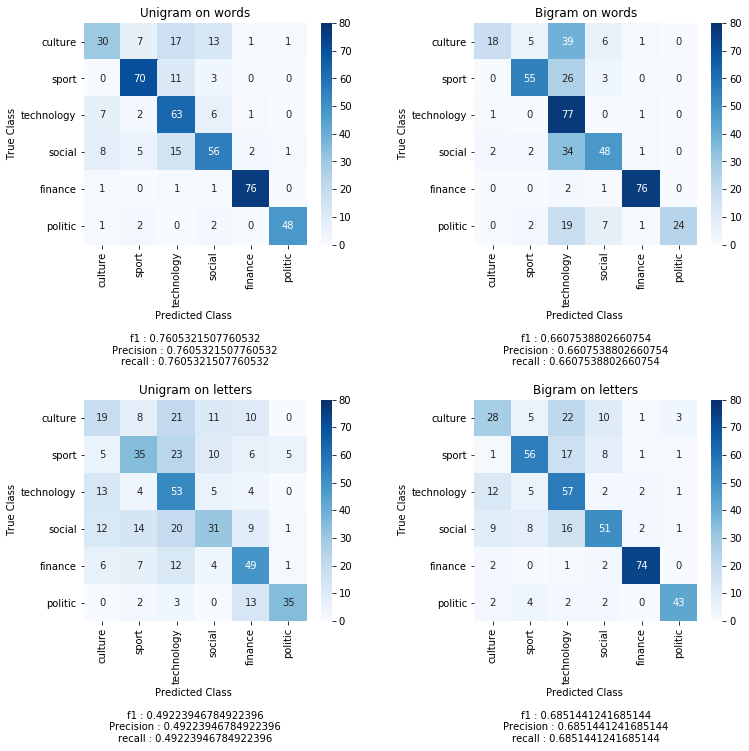

In [208]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sn

model_real_names = {
    'word1' : 'Unigram on words',
    'word2' : 'Bigram on words',
    'letter1' : 'Unigram on letters',
    'letter2' : 'Bigram on letters'
}

fig, axes = plt.subplots(2, 2, figsize=(12,11))
fig.subplots_adjust(hspace=0.7, wspace=0.4)
for i,model in enumerate(models) :
    l,p = data_frame[model]['label'].tolist(), data_frame[model]['predict'].tolist()
    cm = confusion_matrix(l,p)
    df_cm = pd.DataFrame(cm, index = texts.keys(), columns = texts.keys())
    ax = axes[i//2, i%2]
    sn.heatmap(df_cm, annot=True, cmap="Blues", ax=ax, vmax=80)
    ax.set_title(model_real_names[model])
    ax.set_ylabel('True Class')
    ax.set_xlabel('Predicted Class \n\n'
        'f1 : ' + str(f1_score(l,p, average='micro')) + '\n' + \
        'Precision : ' + str(precision_score(l,p, average='micro')) + '\n' + \
        'recall : ' + str(recall_score(l,p, average='micro'))
    )
plt.show()

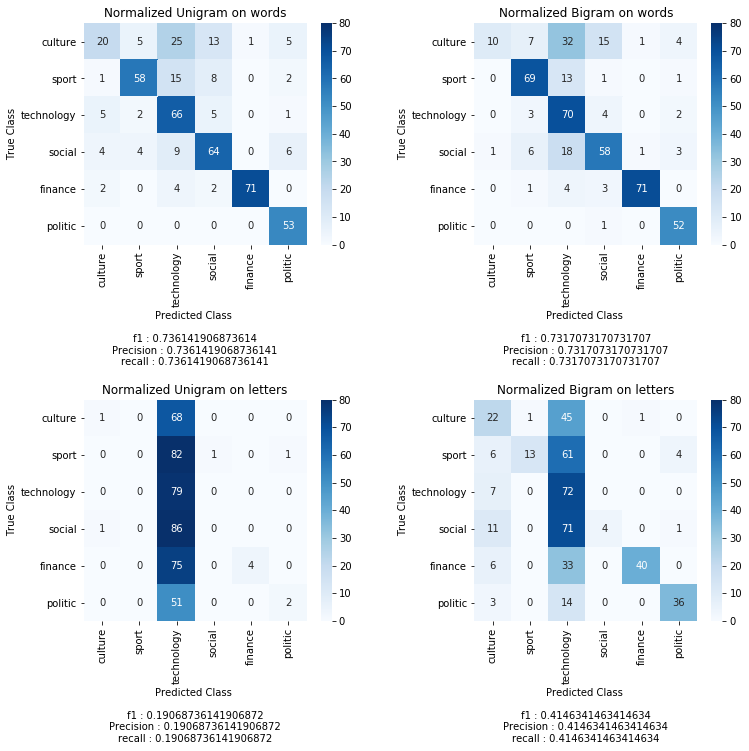

In [210]:
from sklearn import preprocessing

fig, axes = plt.subplots(2, 2, figsize=(12,11))
fig.subplots_adjust(hspace=0.7, wspace=0.4)
for i,model in enumerate(models) :
    df = data_frame[model].copy()[texts.keys()]
    df = pd.DataFrame(preprocessing.MinMaxScaler().fit_transform(df.values), columns=texts.keys())
    df['label'] = data_frame[model]['label']
    df['predict'] = df[texts.keys()].idxmin(axis=1)
    l,p = df['label'].tolist(), df['predict'].tolist()
    cm = confusion_matrix(l,p)
    df_cm = pd.DataFrame(cm, index = texts.keys(), columns = texts.keys())
    ax = axes[i//2,i%2]
    sn.heatmap(df_cm, annot=True, cmap="Blues", ax=ax, vmax=80)
    ax.set_title('Normalized '+model_real_names[model])
    ax.set_ylabel('True Class')
    ax.set_xlabel('Predicted Class \n\n'
        'f1 : ' + str(f1_score(l,p, average='micro')) + '\n' + \
        'Precision : ' + str(precision_score(l,p, average='micro')) + '\n' + \
        'recall : ' + str(recall_score(l,p, average='micro'))
    )
plt.show()

In [198]:
final_test_df = pd.DataFrame({
    'data': final_test.test_ngrams(1),
    'Filename': final_test.test_names
})
set_perplexities('word1', final_test_df)
final_test_df.to_csv('final_test.csv', index=False)

word1 culture done!
word1 sport done!
word1 technology done!
word1 social done!
word1 finance done!
word1 politic done!


In [204]:
final_test_df['Class'] = final_test_df[texts.keys()].idxmin(axis=1)
final_test_df[['Filename','Class']].to_csv('Result.csv', index=False)